In [ ]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_validate 
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score
from catboost import CatBoostClassifier, Pool, cv, FeaturesData

import shap
import joblib

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from back_func import forward_backward                  # самописная

In [2]:
f = 100                                         # кол-во фичей

X, y = make_classification(n_samples=5_000,     # строк
                           n_features= f, 
                           n_informative=40,    # что-то типа количества информативных 
                           weights=[0.7, 0.3],  # дисбаланс классов 
                           random_state=42)  

In [ ]:
df = pd.concat( [ pd.DataFrame( X, columns=['col_'+str(i) for i in range(f)] ), pd.Series(y).rename('target') ], axis=1 )

for col in [i for i in df.columns if 'col' in i]:
    df[col] = df[col] * pd.Series([random.random() for num in range(len(df))]).rename('random')             # умножаем на рандом

#### Обучение

In [4]:
X = df.drop('target', axis=1)
y = df['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [6]:
# custom_loss будет задавать какие скоры мы увидим в get_best_score()

model = CatBoostClassifier(random_state=9, custom_loss=['AUC', 'Accuracy'])

model.fit(X = X_train, 
          y = y_train, 
          eval_set=(X_test, y_test), 
          verbose=False) 

In [7]:
model.get_best_score()

{'learn': {'Accuracy': 1.0, 'Logloss': 0.017087987163209768},
 'validation': {'Accuracy': 0.9,
  'Logloss': 0.2471302270426608,
  'AUC': 0.9594340012394134}}

In [8]:
model.get_best_score()['validation']['AUC']

0.9594340012394134

In [9]:
def objective(search_space):
    model = CatBoostClassifier(
        **search_space,)
    
    model.fit(X = X_train, 
              y = y_train, 
              #cat_features=features_cat,      
              eval_set=(X_test, y_test), 
              verbose=False)               # либо cat_features, либо перекодировать
                                                                                                    
    return {
        'loss': -model.get_best_score()['validation']['AUC'], 'status': STATUS_OK}


search_space = {
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),                   # скорость обучения (шаг градиента)
    'n_estimators' :  10000,                                                    # Максимальное количество деревьев
    'od_type' : 'Iter',
    'od_wait' : 1,
    'l2_leaf_reg' : hp.randint('l2_leaf_reg', 1000, 2000),                      # Коэффициент при члене регуляризации L2 функции стоимости (было 1000, 2000)
    'depth' : hp.randint('depth', 3, 6),                                        # Глубина деревьев
    'bagging_temperature' : hp.uniform('bagging_temperature', 0.01, 0.999),     # Определяет настройки байесовской начальной загрузки
    'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian']),               # Определяет метод выборки весов объектов
    'boosting_type' : hp.choice('boosting_type', ['Ordered','Plain']),          # Схема повышения
    'loss_function' : hp.choice('loss_function', ['Logloss']),                  # Метрика, которую следует использовать в обучении
    'random_strength' : hp.uniform('random_strength', 0.001, 0.999),            # Степень случайности, используемая для оценки разделений 
#    'class_weights': hp.choice('class_weights', [None, class_weights]),
                                                                                # при выборе древовидной структуры. 
                                                                                # Используйте этот параметр, чтобы избежать переобучения модели.
    'custom_loss': 'AUC'}                                                       #


algorithm=tpe.suggest

trials = Trials()

best_params = fmin(
    fn=objective,
    space=search_space,
    algo=algorithm,
    max_evals=20, 
    trials=trials)

hyperparams = space_eval(search_space, best_params)
hyperparams

100%|██████████| 20/20 [00:57<00:00,  2.87s/trial, best loss: -0.9214480479239826]


{'bagging_temperature': 0.02802307112943772,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'custom_loss': 'AUC',
 'depth': 5,
 'l2_leaf_reg': 1833,
 'learning_rate': 0.1047176137604113,
 'loss_function': 'Logloss',
 'n_estimators': 10000,
 'od_type': 'Iter',
 'od_wait': 1,
 'random_strength': 0.8144282557636047}

In [10]:
hyperparams.pop('od_type', None)
hyperparams.pop('od_wait', None)
hyperparams['n_estimators'] = 100 # ручной подбор -> оверфит около 0.02 - 0.05

model = CatBoostClassifier(
    **hyperparams,
    verbose=False,                # если хотим, что бы отписывал строки - ставим шаг итераций, например, 50
)

model.fit(
    X_train, 
    y_train, 
    #cat_features=features_cat, 
    eval_set=(X_test, y_test), 
    plot=False)

roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
gini_train = 2 * roc_auc_train - 1
gini_test = 2 * roc_auc_test - 1
print('roc_auc train - {}'.format(roc_auc_train))
print('gini train - {}'.format(gini_train))
print('-'*50)
print('roc_auc test - {}'.format(roc_auc_test))
print('gini test - {}'.format(gini_test))
print('-'*50)
print('Overfitting - {}'.format(gini_train - gini_test))

roc_auc train - 0.8777358038720341
gini train - 0.7554716077440682
--------------------------------------------------
roc_auc test - 0.8478702747366246
gini test - 0.6957405494732491
--------------------------------------------------
Overfitting - 0.05973105827081904


In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap_sum = np.abs(shap_values).mean(axis=0)

# по шап
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['feature', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=True)

# по модели
importance_df_model = pd.concat( [pd.Series(model.feature_names_).rename('feature'), pd.Series(model.feature_importances_).rename('model_importance')], axis=1 )
importance_df_model = importance_df_model.sort_values('model_importance', ascending=True)

features_shap = list(importance_df['feature'])
features_model = list(importance_df_model['feature'])

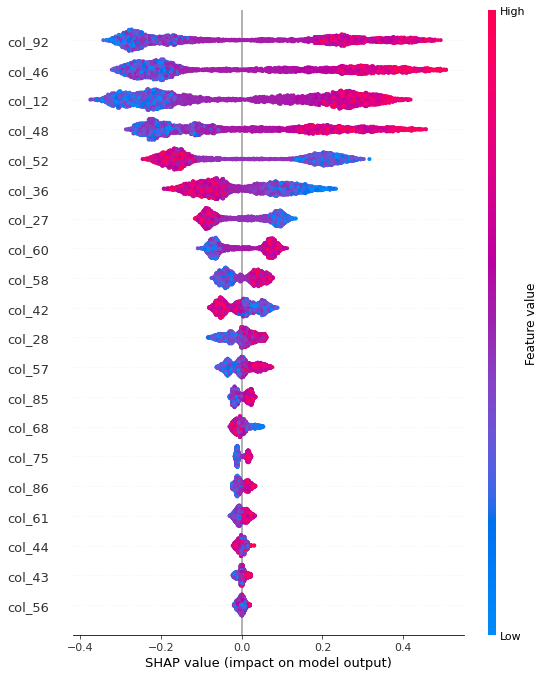

In [12]:
shap.summary_plot(shap_values, X_train, max_display=20)

In [13]:
# importance_df

In [14]:
# importance_df_model

In [15]:
# по шапу от самого бесполезного к самому лучшему

# features_shap

In [16]:
# по модели от самого бесполезного к самому лучшему

# features_model

#### Backward elimination

#### ----------------------------------------------- 

In [17]:
features_ = features_shap.copy()

In [18]:
features_shap[0]

'col_49'

In [19]:
# для backward elemination мы поочередно отбрасываем наименее значимые фичи по шапу
# график будет построен как бы справа налево

# все записываем в словарь с инфой по обучению

stop = False       # False or int - ограничение на количество итераций 

info = {
    'feature' : [],
    'num_features' : [],
    'mean_gini_cv_valid' : [],
    'std_gini_cv_valid' : [],
    'mean_gini_cv_train' : [],
    'std_gini_cv_train' : [],
    'gini_train' : [],
    'gini_test' : [],
    'overfit' : []
}

                
for feature in tqdm(features_shap, total=len(features_shap) - 1):

    features_ = list(set(features_) - set([feature]))   # убираем из списка фичей для обучения ненужную фичу
    
    # model = CatBoostClassifier(
    #     **hyperparams,
    #     verbose=False,)
    
    if not features_ or (stop and len(features_) < stop):          # когда убрали до нуля или проставили порог - останавливаемся
        break
    
# ------------- кросс валидация ----------------    
    cv_data = cross_validate(                           # смотрим 10 (cv) кроссвалидационных скоров
        model, 
        X_train[features_], 
        y_train,
        scoring='roc_auc',
        return_train_score=True, 
        cv=6, 
        #error_score='raise'
    )
    valid_cv_gini = 2 * cv_data['test_score'] - 1      # считаем np.array значений gini для тестовых выборок
    train_cv_gini = 2 * cv_data['train_score'] - 1     # считаем np.array значений gini для трейн выборок

# ------------ обучение и расчет параметров -------------

    model.fit(
        X_train[features_], 
        y_train, 
        #cat_features=cat_features_, 
        eval_set=(X_test[features_], y_test), 
        plot=False)
    
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features_])[:, 1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features_])[:, 1])
    
    gini_train = 2 * roc_auc_train - 1
    gini_test = 2 * roc_auc_test - 1
    
# ---------------------Запоминаем ------------------------
    
    info['feature'].append(feature)                                    # имя отброшенной фичи
    info['num_features'].append(len(features_))                        # длина оставшегося количества фичей
    info['mean_gini_cv_valid'].append(np.mean(valid_cv_gini))          # среднее по тестовым джини на кросс валидации для текущего кол-ва фичей
    info['std_gini_cv_valid'].append(np.std(valid_cv_gini))            # стандартное отклонение по тестовым джини на кросс валидации для текущего кол-ва фичей
    info['mean_gini_cv_train'].append(np.mean(train_cv_gini))          # среднее по трейн джини на кросс валидации для текущего кол-ва фичей
    info['std_gini_cv_train'].append(np.std(train_cv_gini))            # стандартное отклонение по трейн джини на кросс валидации для текущего кол-ва фичей
    info['gini_train'].append(gini_train)                              # джини трейн для данного количества фичей
    info['gini_test'].append(gini_test)                                # джини тест для данного количества фичей
    info['overfit'].append(gini_train - gini_test)                     # оверфит для данного количества фичей

  0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

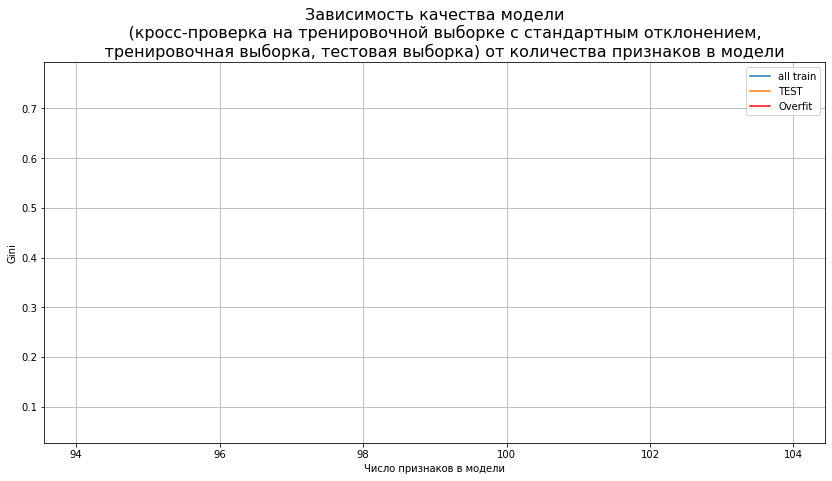

In [20]:
fig = plt.figure(figsize=(14, 7))

# plt.errorbar(
#     info['num_features'], 
#     info['mean_gini_cv_train'],           # среднее кросс-валидационное джини на трейн выборках
#     yerr=info['std_gini_cv_train'],       # стандарное отклонение по трейн джини на кросс валидации    
#     label='cv train')                    

# plt.errorbar(
#     info['num_features'], 
#     info['mean_gini_cv_valid'],         # среднее кросс-валидационное джини на тест выборках
#     info['std_gini_cv_valid'],          # стандарное отклонение по тест джини на кросс валидации
#     label = 'cv valid')

plt.plot(
    info['num_features'], 
    info['gini_train'],                   # джини трейн 
    label = 'all train')

plt.plot(
    info['num_features'], 
    info['gini_test'],                    # джини тест
    label = 'TEST')

plt.plot(
    info['num_features'], 
    info['overfit'],                      # оверфит
    label = 'Overfit', 
    color='r')

plt.title(
    '''Зависимость качества модели
    (кросс-проверка на тренировочной выборке с стандартным отклонением,
    тренировочная выборка, тестовая выборка) от количества признаков в модели''', fontsize=16)
plt.xlabel('Число признаков в модели')
plt.ylabel('Gini')
plt.legend()
# plt.ylim(0.42, 0.46)
plt.grid()
plt.show()

In [35]:
# смотрим, выбираем сколько оставить

num_top_features = 22

result_features_for_model_fit = features_shap[-num_top_features:]

#### forward selection

In [36]:
features_ = features_shap[::-1].copy()

In [37]:
features_[0]

'col_92'

In [38]:
# для forward slection мы поочередно добавляем наиболее значимые фичи по шапу 
# этот график (в отличие от backward elimination) уже будет построен справа налево 

# все записываем в словарь с инфой по обучению

stop = False       # False or int - ограничение на количество итераций 

features_ = set()

info = {
    'feature' : [],
    'num_features' : [],
    'mean_gini_cv_valid' : [],
    'std_gini_cv_valid' : [],
    'mean_gini_cv_train' : [],
    'std_gini_cv_train' : [],
    'gini_train' : [],
    'gini_test' : [],
    'overfit' : []
}

for feature in tqdm(features_shap[::-1], total=len(features_shap) ):

    features_ = list(set(features_) | set([feature]))   # объединяем множество features_ и текущую фичу
    
    # model = CatBoostClassifier(
    #     **hyperparams,
    #     verbose=False,)
    
    if not features_ or (stop and len(features_) > stop):          # когда убрали до нуля или проставили порог - останавливаемся
        break
        
# ------------- кросс валидация ----------------    
    cv_data = cross_validate(                           # смотрим 10 (cv) кроссвалидационных скоров
        model, 
        X_train[features_], 
        y_train,
        scoring='roc_auc',
        return_train_score=True, 
        cv=6, 
        #error_score='raise'
    )
    valid_cv_gini = 2 * cv_data['test_score'] - 1      # считаем np.array значений gini для тестовых выборок
    train_cv_gini = 2 * cv_data['train_score'] - 1     # считаем np.array значений gini для трейн выборок

# ------------ обучение и расчет параметров -------------
    
    model.fit(
        X_train[features_], 
        y_train, 
        #cat_features=cat_features_, 
        eval_set=(X_test[features_], y_test), 
        plot=False)
    
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features_])[:, 1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features_])[:, 1])
    
    gini_train = 2 * roc_auc_train - 1
    gini_test = 2 * roc_auc_test - 1
    
# ---------------------Запоминаем ------------------------
    
    info['feature'].append(feature)                                    # имя отброшенной фичи
    info['num_features'].append(len(features_))                        # длина оставшегося количества фичей
    info['mean_gini_cv_valid'].append(np.mean(valid_cv_gini))          # среднее по тестовым джини на кросс валидации для текущего кол-ва фичей
    info['std_gini_cv_valid'].append(np.std(valid_cv_gini))            # стандартное отклонение по тестовым джини на кросс валидации для текущего кол-ва фичей
    info['mean_gini_cv_train'].append(np.mean(train_cv_gini))          # среднее по трейн джини на кросс валидации для текущего кол-ва фичей
    info['std_gini_cv_train'].append(np.std(train_cv_gini))            # стандартное отклонение по трейн джини на кросс валидации для текущего кол-ва фичей
    info['gini_train'].append(gini_train)                              # джини трейн для данного количества фичей
    info['gini_test'].append(gini_test)                                # джини тест для данного количества фичей
    info['overfit'].append(gini_train - gini_test)                     # оверфит для данного количества фичей

  0%|          | 0/100 [00:00<?, ?it/s]

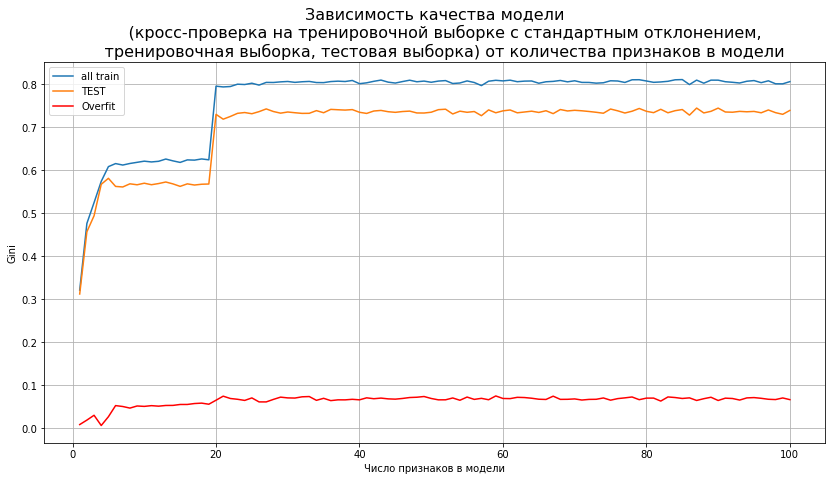

In [39]:
fig = plt.figure(figsize=(14, 7))

# plt.errorbar(
#     info['num_features'], 
#     info['mean_gini_cv_train'],           # среднее кросс-валидационное джини на трейн выборках
#     yerr=info['std_gini_cv_train'],       # стандарное отклонение по трейн джини на кросс валидации    
#     label='cv train')                    

# plt.errorbar(
#     info['num_features'], 
#     info['mean_gini_cv_valid'],         # среднее кросс-валидационное джини на тест выборках
#     info['std_gini_cv_valid'],          # стандарное отклонение по тест джини на кросс валидации
#     label = 'cv valid')

plt.plot(
    info['num_features'], 
    info['gini_train'],                   # джини трейн 
    label = 'all train')

plt.plot(
    info['num_features'], 
    info['gini_test'],                    # джини тест
    label = 'TEST')

plt.plot(
    info['num_features'], 
    info['overfit'],                      # оверфит
    label = 'Overfit', 
    color='r')

plt.title(
    '''Зависимость качества модели
    (кросс-проверка на тренировочной выборке с стандартным отклонением,
    тренировочная выборка, тестовая выборка) от количества признаков в модели''', fontsize=16)
plt.xlabel('Число признаков в модели')
plt.ylabel('Gini')
plt.legend()
# plt.ylim(0.42, 0.46)
plt.grid()
plt.show()

####
#### -----------------------------------------------------------------------------------------

In [41]:
# или юзаем готовую функцию

info = forward_backward(X_train, X_test, y_train, y_test, features_shap=features_shap, model=model, type_selection='backward')
#info = forward_backward(X_train, X_test, y_train, y_test, features_shap=features_shap, model=model, type_selection='forward')

  0%|          | 0/99 [00:00<?, ?it/s]

In [43]:
# info

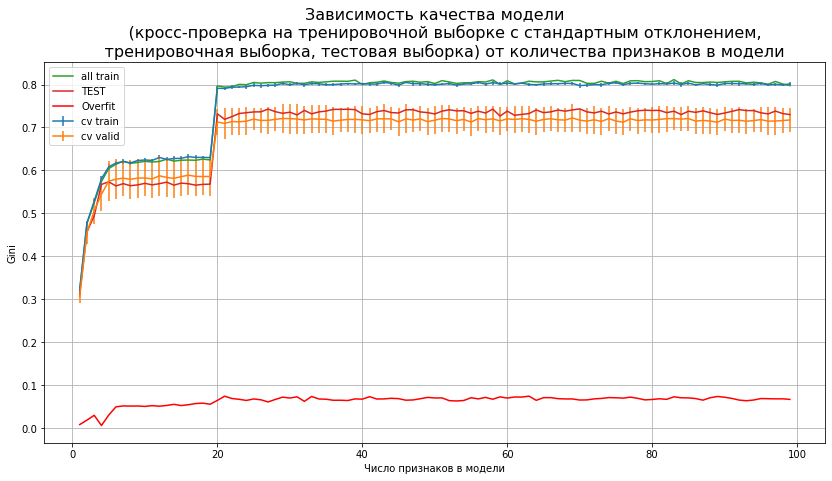

In [44]:
fig = plt.figure(figsize=(14, 7))

plt.errorbar(
    info['num_features'], 
    info['mean_gini_cv_train'],           # среднее кросс-валидационное джини на трейн выборках
    yerr=info['std_gini_cv_train'],       # стандарное отклонение по трейн джини на кросс валидации    
    label='cv train')                    

plt.errorbar(
    info['num_features'], 
    info['mean_gini_cv_valid'],         # среднее кросс-валидационное джини на тест выборках
    info['std_gini_cv_valid'],          # стандарное отклонение по тест джини на кросс валидации
    label = 'cv valid')

plt.plot(
    info['num_features'], 
    info['gini_train'],                   # джини трейн 
    label = 'all train')

plt.plot(
    info['num_features'], 
    info['gini_test'],                    # джини тест
    label = 'TEST')

plt.plot(
    info['num_features'], 
    info['overfit'],                      # оверфит
    label = 'Overfit', 
    color='r')

plt.title(
    '''Зависимость качества модели
    (кросс-проверка на тренировочной выборке с стандартным отклонением,
    тренировочная выборка, тестовая выборка) от количества признаков в модели''', fontsize=16)
plt.xlabel('Число признаков в модели')
plt.ylabel('Gini')
plt.legend()
# plt.ylim(0.42, 0.46)
plt.grid()
plt.show()